# Intersection with 500 samples

In [6]:
#bbox to validate the algorithm1 and to create the dataset
import geopandas as gpd 

gdf_sampled_bbox = gpd.read_parquet('~/repo/Disturbance-Attribution-Dataset-Joining/data/results/sampling/sampled_bboxes.parquet').to_crs('EPSG:32631')
gdf_features = gpd.read_parquet('~/repo/Disturbance-Attribution-Dataset-Joining/data/results/sampling/sampled_features.parquet').to_crs('EPSG:32631')

from tqdm import tqdm 
for i, row in tqdm(enumerate(gdf_sampled_bbox.itertuples())):
    bbox = gdf_features[ gdf_features['bbox'] == i ]
    start_date = bbox['start_date'].min()
    end_date = bbox['end_date'].max()
    gdf_sampled_bbox.loc[i, 'start_date'] = start_date
    gdf_sampled_bbox.loc[i, 'end_date'] = end_date

#add tzinfo to start_date and end_date
from datetime import timezone
gdf_sampled_bbox.start_date = gdf_sampled_bbox.start_date.dt.tz_localize(timezone.utc) 
gdf_sampled_bbox.end_date = gdf_sampled_bbox.end_date.dt.tz_localize(timezone.utc) 

399it [00:00, 536.07it/s]


In [2]:
species = gpd.read_file('/Users/arthurcalvi/Data/species/france_species.shp').to_crs('EPSG:32631')

NameError: name 'gpd' is not defined

In [13]:
species

,year,specie_fr,specie_en,specie_lat,genus_fr,genus_en,genus_lat,lf_fr,lf_en,phen_fr,phen_en,source,id,class,geometry
0,2015,chene sessile,sessile oak,quercus petraea,chene,oak,quercus,feuilles,broadleaf,decidu,deciduous,DSF,0,deciduous oak,"POLYGON ((650874.874 5511105.459, 650854.874 5..."
1,2015,sapin de nordmann,caucasian fir,abies nordmanniana,sapin,fir,abies,aiguilles,needleleaf,sempervirent,evergreen,DSF,1,fir,"POLYGON ((803838.966 5356002.897, 803818.966 5..."
2,2015,pin noir,black pine,pinus nigra,pin,pine,pinus,aiguilles,needleleaf,sempervirent,evergreen,DSF,2,black pine,"POLYGON ((765871.221 4935666.771, 765851.221 4..."
3,2015,pin noir,black pine,pinus nigra,pin,pine,pinus,aiguilles,needleleaf,sempervirent,evergreen,DSF,3,black pine,"POLYGON ((273787.168 4770757.969, 273767.168 4..."
4,2015,pin noir,black pine,pinus nigra,pin,pine,pinus,aiguilles,needleleaf,sempervirent,evergreen,DSF,4,black pine,"POLYGON ((274426.318 4770781.298, 274406.318 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189218,2022,None,None,None,sapin,fir,abies,aiguilles,needleleaf,sempervirent,evergreen,PureForest,191016,fir,"POLYGON ((554354.516 4953570.258, 554304.511 4..."
189219,2022,None,None,None,sapin,fir,abies,aiguilles,needleleaf,sempervirent,evergreen,PureForest,191017,fir,"POLYGON ((554404.522 4953570.245, 554354.516 4..."
189220,2022,None,None,None,sapin,fir,abies,aiguilles,needleleaf,sempervirent,evergreen,PureForest,191018,fir,"POLYGON ((554454.527 4953570.232, 554404.522 4..."
189221,2022,None,None,None,sapin,fir,abies,aiguilles,needleleaf,sempervirent,evergreen,PureForest,191019,fir,"POLYGON ((554404.509 4953520.240, 554354.503 4..."


In [26]:
import geopandas as gpd
import pandas as pd

def calculate_intersection_percentage(sentinel_gdf: gpd.GeoDataFrame, tree_species_gdf: gpd.GeoDataFrame) -> pd.DataFrame:
    """
    Calculate the percentage of area of Sentinel-2 bounding boxes that contain tree species information for the corresponding years.

    Parameters:
    sentinel_gdf (gpd.GeoDataFrame): Geodataframe containing Sentinel-2 bounding boxes with start and end dates.
    tree_species_gdf (gpd.GeoDataFrame): Geodataframe containing tree species polygons with date information.

    Returns:
    pd.DataFrame: A dataframe with Sentinel-2 bounding box IDs, years, and intersection percentages.
    """
    
    results = []
    for sentinel_row in sentinel_gdf.itertuples():
        # Filter tree species data for the year of the current sentinel row within the date range
        start_year = sentinel_row.start_date.year
        end_year = sentinel_row.end_date.year
        
        tree_species_year_gdf = tree_species_gdf[
            tree_species_gdf['year'].dt.year.between(start_year, end_year)
        ]

        # Find intersections
        intersections = tree_species_year_gdf[tree_species_year_gdf.intersects(sentinel_row.geometry)]
        
        # Calculate intersection area
        total_intersection_area = intersections.geometry.intersection(sentinel_row.geometry).area.sum()
        num_pixels = total_intersection_area / 100  # since 1 pixel = 100 square meters

        results.append({
            'sentinel_id': sentinel_row.Index,  # Assuming there's an 'id' column in your sentinel data
            'year_range': f"{start_year}-{end_year}",
            'intersection_pixels': num_pixels,
            'geometry': intersections.geometry.unary_union
        })
    
    return gpd.GeoDataFrame(results, crs=sentinel_gdf.crs)

# Load your geodataframes
sentinel_gdf = gdf_sampled_bbox
tree_species_gdf = species # Update with your file path

# Convert date columns to datetime
sentinel_gdf['start_date'] = pd.to_datetime(sentinel_gdf['start_date'])
sentinel_gdf['end_date'] = pd.to_datetime(sentinel_gdf['end_date'])
tree_species_gdf['year'] = pd.to_datetime(tree_species_gdf['year'])

# Compute the intersection percentages
intersection_df = calculate_intersection_percentage(sentinel_gdf, tree_species_gdf)

# Display the results
from IPython.display import display
display(intersection_df)




/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_2799/2227150382.py:37: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  'geometry': intersections.geometry.unary_union
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_2799/2227150382.py:37: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  'geometry': intersections.geometry.unary_union
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_2799/2227150382.py:37: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  'geometry': intersections.geometry.unary_union
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_2799/2227150382.py:37: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` w

,sentinel_id,year_range,intersection_pixels,geometry
0,0,2017-2020,36.000000,"MULTIPOLYGON (((422532.733 5310366.512, 422532..."
1,1,2017-2020,20.000000,"MULTIPOLYGON (((637211.657 5146172.922, 637231..."
2,2,2014-2021,40.000000,"MULTIPOLYGON (((775095.262 5245050.040, 775095..."
3,3,2017-2021,16.000000,"MULTIPOLYGON (((828579.781 5450769.917, 828599..."
4,4,2012-2021,56.000000,"MULTIPOLYGON (((705439.034 5169593.060, 705439..."
...,...,...,...,...
394,394,2017-2020,28.000000,"MULTIPOLYGON (((449086.112 4758161.196, 449106..."
395,395,2017-2020,28.000000,"MULTIPOLYGON (((439831.991 5445709.959, 439851..."
396,396,2017-2020,12.000000,"MULTIPOLYGON (((473015.834 5237523.553, 473015..."
397,397,2017-2020,24.000000,"MULTIPOLYGON (((453171.473 4770100.623, 453191..."


In [27]:
intersection_df.intersection_pixels.sum() 

12750.550222065918

# Select new AOIs 

In [1]:
# Example usage
import geopandas as gpd
species = gpd.read_file('/Users/arthurcalvi/Data/species/france_species.shp').to_crs('EPSG:32631')

[100000.0, 50000.0, 25000.0, 12500.0, 5000.0]
Processing grid size: 100000.0


132it [00:00, 147.07it/s]


Conversion : 63%
Processing grid size: 50000.0


506it [00:02, 200.52it/s]


Conversion : 54%
Processing grid size: 25000.0


1935it [00:06, 311.98it/s]


Conversion : 50%
Processing grid size: 12500.0


7650it [00:17, 446.08it/s] 


Conversion : 47%
Processing grid size: 5000.0


47053it [02:12, 355.44it/s] 


Conversion : 36%


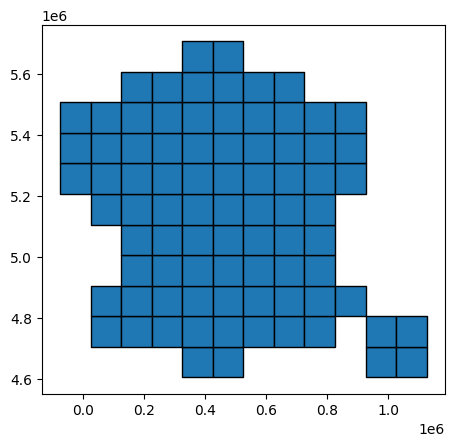

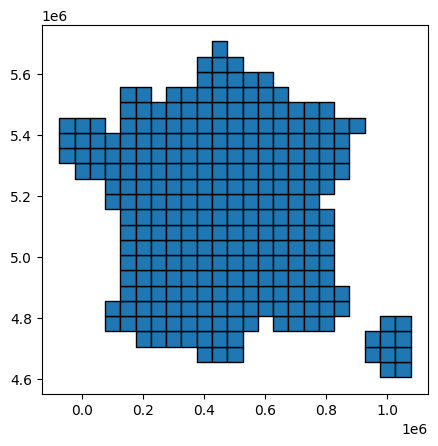

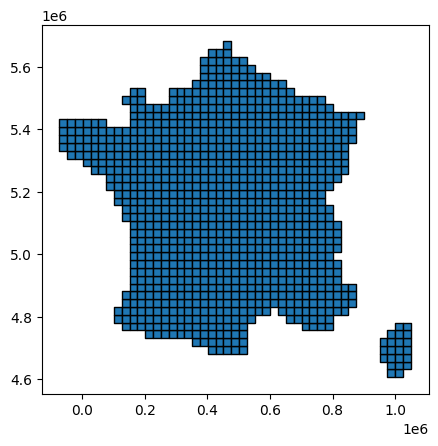

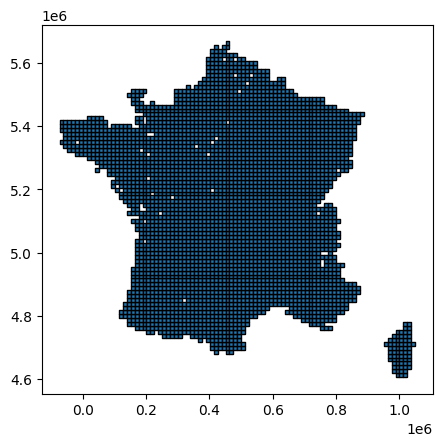

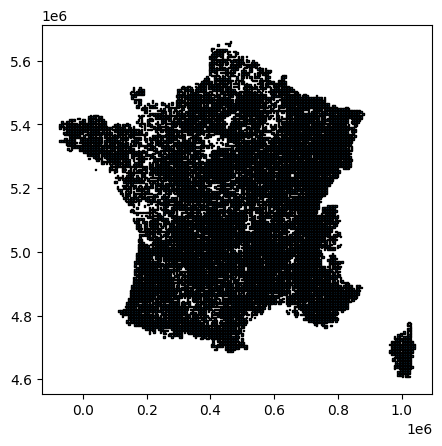

In [133]:
import numpy as np 
import geopandas as gpd
from shapely.geometry import box 
from shapely import unary_union
from tqdm import tqdm

# Calculate the different grid sizes
initial_grid_size = 100e3
aoi_size = 5e3

sizes = [initial_grid_size]
while sizes[-1] > 3*aoi_size:
    a = sizes[-1] // 2
    sizes.append(max(a, aoi_size))

sizes.append(aoi_size)
print(sizes)
minx, miny, maxx, maxy = species.envelope.total_bounds

boundary_species = species.geometry.simplify(5000).unary_union
# Create a list to hold selected AOIs
new_boundaries = gpd.GeoDataFrame(geometry=[box(minx, miny, maxx, maxy)], crs=species.crs)


for i, current_grid_size in enumerate(sizes):
    print(f"Processing grid size: {current_grid_size}")
    # Determine the bounds for the current iteration
    
    # Generate a grid of AOIs
    x_coords = np.arange(minx, maxx, current_grid_size)
    y_coords = np.arange(miny, maxy, current_grid_size)
    
    # Create polygons for the AOIs
    aoi_polygons = []
    for x in x_coords:
        for y in y_coords:
            aoi = box(x, y, x + current_grid_size, y + current_grid_size)
            aoi_polygons.append(aoi)
    
    # Create a GeoDataFrame from the AOIs
    aois = gpd.GeoDataFrame(geometry=aoi_polygons, crs=species.crs)
   
    # Calculate the intersection of each AOI with the species dataset
    selected_aois = []
    bounds = new_boundaries.unary_union
    for row in tqdm(aois.itertuples()):
        if row.geometry.intersects(bounds) and row.geometry.intersects(boundary_species):
            selected_aois.append(row.geometry)
    
    print(F'Conversion : {len(selected_aois)/aois.shape[0] :.0%}')
    
    # Update new_boundaries for the next iteration
    
    new_boundaries = gpd.GeoDataFrame(geometry=selected_aois, crs=species.crs)
    new_boundaries.plot(edgecolor='k')
    

In [140]:
perc = []
geom = []
for row in tqdm(new_boundaries.itertuples()):
    intersection = boundary_species.intersection(row.geometry)
    intersection_area = intersection.area
    aoi_area = aoi.area
    intersection_percent = (intersection_area / aoi_area) * 100
    perc.append(intersection_percent)
    geom.append(row.geometry)

gdf_intersection = gpd.GeoDataFrame(data=perc, geometry=geom, columns=['perc'], crs=species.crs)
    

16967it [17:10, 16.47it/s]


ValueError: Shape of passed values is (16967, 1), indices imply (16967, 2)

In [141]:
gdf_intersection = gpd.GeoDataFrame(data=perc, geometry=geom, columns=['perc'], crs=species.crs)

In [144]:
gdf_intersection.to_parquet('/Users/arthurcalvi/Data/species/5km_cell_percentage.parquet')

In [2]:
gdf_intersection = gpd.read_parquet('/Users/arthurcalvi/Data/species/5km_cell_percentage.parquet').to_crs('epsg:2154')
gdf_intersection

,perc,geometry
0,0.0032,"POLYGON ((131725.851 6795590.647, 131712.617 6..."
1,0.0032,"POLYGON ((131609.928 6835427.052, 131593.818 6..."
2,0.0016,"POLYGON ((131593.818 6840407.137, 131577.348 6..."
3,0.0016,"POLYGON ((131577.348 6845387.352, 131560.516 6..."
4,0.0048,"POLYGON ((136705.142 6795603.652, 136692.010 6..."
...,...,...
16962,0.0096,"POLYGON ((1236264.201 6162845.015, 1236235.931..."
16963,0.0032,"POLYGON ((1236235.931 6167837.189, 1236207.970..."
16964,0.0016,"POLYGON ((1241343.843 6147896.355, 1241314.368..."
16965,0.0016,"POLYGON ((1241314.368 6152889.036, 1241285.205..."


<Axes: >

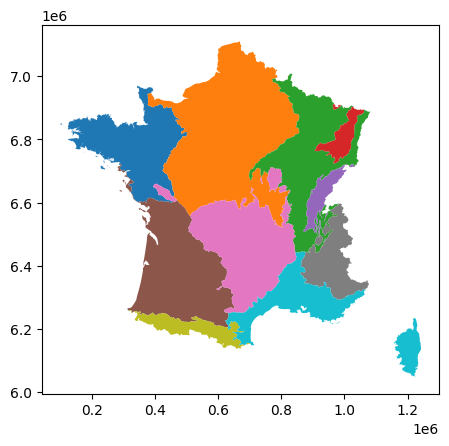

In [3]:
greco = gpd.read_file('/Users/arthurcalvi/Data/eco-regions/France/ser_l93_new/ser_l93_new.dbf')
greco['greco'] = greco.codeser.apply(lambda x:x[0])
greco = greco.dissolve(by='greco', aggfunc='first')
greco = greco.reset_index().iloc[1:].to_crs('EPSG:2154')
greco.plot(column='codeser')

In [6]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import numpy as np

def sample_gdf_intersection(gdf_intersection: gpd.GeoDataFrame, greco: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Sample from gdf_intersection based on greco regions, create training and validation sets.
    """
    result = []

    for region in tqdm(greco.itertuples()):
        # Clip gdf_intersection with the current greco region
        clipped = gpd.clip(gdf_intersection, region.geometry)
        
        if not clipped.empty:
            # Sort by 'perc' and keep the 8 highest rows
            clipped_sorted = clipped.sort_values(by='perc', ascending=False).head(8)
            
            # Randomly split into training and validation sets
            clipped_sorted['set'] = np.where(np.random.rand(len(clipped_sorted)) < 0.5, 'training', 'validation')
            
            # Ensure 4 for training and 4 for validation
            training_set = clipped_sorted[clipped_sorted['set'] == 'training'].head(4)
            validation_set = clipped_sorted[clipped_sorted['set'] == 'validation'].head(4)
            
            if len(training_set) < 4:
                additional_training = clipped_sorted[clipped_sorted['set'] == 'validation'].tail(4 - len(training_set))
                training_set = pd.concat([training_set, additional_training])
            
            if len(validation_set) < 4:
                additional_validation = clipped_sorted[clipped_sorted['set'] == 'training'].tail(4 - len(validation_set))
                validation_set = pd.concat([validation_set, additional_validation])
            
            # Append the training and validation sets to the result
            for set_type, data in zip(['training', 'validation'], [training_set, validation_set]):
                data['set'] = set_type
                data['NomSER'] = region.NomSER
                result.append(data)
    
    # Combine all results into a single GeoDataFrame
    result_gdf = gpd.GeoDataFrame(pd.concat(result, ignore_index=True), crs=gdf_intersection.crs)
    return result_gdf[['perc', 'set', 'NomSER', 'geometry']]

result_gdf = sample_gdf_intersection(gdf_intersection, greco)




11it [01:10,  6.43s/it]


In [11]:
result_gdf

,perc,set,NomSER,geometry
0,0.025600,training,Ouest-Bretagne et Nord-Cotentin,"POLYGON ((201391.787 6825668.269, 201378.132 6..."
1,0.025600,training,Ouest-Bretagne et Nord-Cotentin,"POLYGON ((336238.524 6721180.268, 336233.204 6..."
2,0.023959,training,Ouest-Bretagne et Nord-Cotentin,"POLYGON ((361093.469 6796078.831, 361085.289 6..."
3,0.020800,training,Ouest-Bretagne et Nord-Cotentin,"POLYGON ((445944.316 6831170.906, 445936.999 6..."
4,0.028800,validation,Ouest-Bretagne et Nord-Cotentin,"POLYGON ((445854.862 6886140.394, 445845.748 6..."
...,...,...,...,...
83,3.793857,training,Corse occidentale,"POLYGON ((1206225.785 6177660.457, 1206200.001..."
84,4.389149,validation,Corse occidentale,"POLYGON ((1186404.594 6147587.251, 1186378.162..."
85,3.649380,validation,Corse occidentale,"POLYGON ((1191400.530 6147613.962, 1191373.821..."
86,3.530134,validation,Corse occidentale,"POLYGON ((1216520.813 6122776.433, 1216491.237..."


In [11]:
species

,year,specie_fr,specie_en,specie_lat,genus_fr,genus_en,genus_lat,lf_fr,lf_en,phen_fr,phen_en,source,id,class,geometry
0,2015,chene sessile,sessile oak,quercus petraea,chene,oak,quercus,feuilles,broadleaf,decidu,deciduous,DSF,0,deciduous oak,"POLYGON ((650874.874 5511105.459, 650854.874 5..."
1,2015,sapin de nordmann,caucasian fir,abies nordmanniana,sapin,fir,abies,aiguilles,needleleaf,sempervirent,evergreen,DSF,1,fir,"POLYGON ((803838.966 5356002.897, 803818.966 5..."
2,2015,pin noir,black pine,pinus nigra,pin,pine,pinus,aiguilles,needleleaf,sempervirent,evergreen,DSF,2,black pine,"POLYGON ((765871.221 4935666.771, 765851.221 4..."
3,2015,pin noir,black pine,pinus nigra,pin,pine,pinus,aiguilles,needleleaf,sempervirent,evergreen,DSF,3,black pine,"POLYGON ((273787.168 4770757.969, 273767.168 4..."
4,2015,pin noir,black pine,pinus nigra,pin,pine,pinus,aiguilles,needleleaf,sempervirent,evergreen,DSF,4,black pine,"POLYGON ((274426.318 4770781.298, 274406.318 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189218,2022,None,None,None,sapin,fir,abies,aiguilles,needleleaf,sempervirent,evergreen,PureForest,191016,fir,"POLYGON ((554354.516 4953570.258, 554304.511 4..."
189219,2022,None,None,None,sapin,fir,abies,aiguilles,needleleaf,sempervirent,evergreen,PureForest,191017,fir,"POLYGON ((554404.522 4953570.245, 554354.516 4..."
189220,2022,None,None,None,sapin,fir,abies,aiguilles,needleleaf,sempervirent,evergreen,PureForest,191018,fir,"POLYGON ((554454.527 4953570.232, 554404.522 4..."
189221,2022,None,None,None,sapin,fir,abies,aiguilles,needleleaf,sempervirent,evergreen,PureForest,191019,fir,"POLYGON ((554404.509 4953520.240, 554354.503 4..."


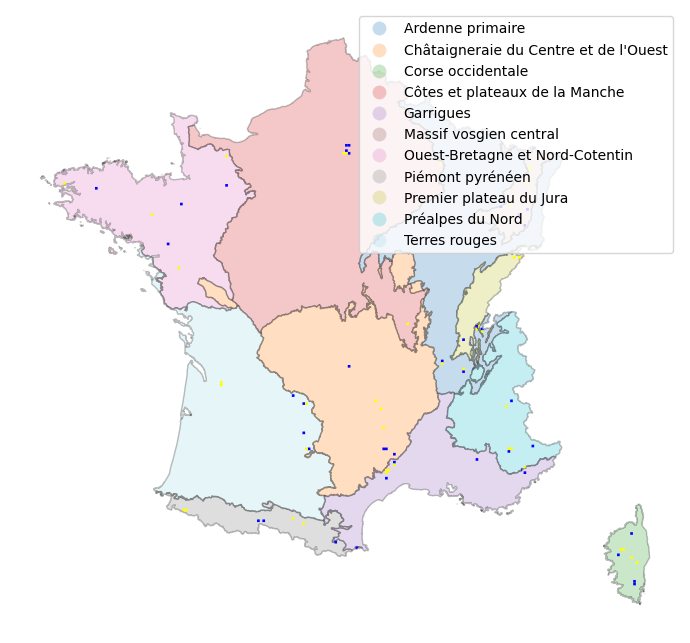

In [27]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd

# Sample data for gdf4
# gdf4 = gpd.read_file("path_to_your_shapefile.shp")

# Create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Define the colormap
colormap = {'validation': 'yellow', 'training': 'blue'}
result_gdf['color'] = result_gdf['set'].map(colormap)

greco.plot(ax=ax, column='NomSER', edgecolor='k', alpha=0.25, cmap='tab20', legend=True)
# Plot the GeoDataFrame with the specified colors
result_gdf.plot(ax=ax, color=result_gdf['color'])

# Add basemap and remove axis
ax.set_axis_off()

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap[key], markersize=10, label=key) for key in colormap]
# ax.legend(handles=handles, title='Set', loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

os.makedirs('images', exist_ok=True)
fig.savefig('images/validation_data.png', dpi=300)


# Write validation data

In [15]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np
from shapely.geometry import box
from typing import List, Tuple, Dict
import os
from tqdm import tqdm 

def create_value_maps(species: gpd.GeoDataFrame) -> Dict[str, Dict[str, int]]:
    """
    Creates a consistent mapping from unique categorical values to integers for all specified columns.
    """
    columns = ['specie_en', 'genus_en', 'phen_en', 'year', 'source']
    value_maps = {}
    
    for column in columns:
        unique_values = species[column].unique()
        value_map = {val: idx + 1 for idx, val in enumerate(unique_values)}
        value_maps[column] = value_map
    
    return value_maps

def process_tile(tile: gpd.GeoDataFrame, species: gpd.GeoDataFrame, value_maps: Dict[str, Dict[str, int]], transform: rasterio.Affine, shape: Tuple[int, int]) -> np.ndarray:
    """
    Clips species data with the tile and rasterizes specified columns using provided value maps.
    """
    clipped = gpd.clip(species, tile.geometry)
    if clipped.empty:
        return np.zeros((len(value_maps), *shape), dtype=np.int32)
    
    rasters = np.zeros((len(value_maps), *shape), dtype=np.int32)
    for i, (column, value_map) in enumerate(value_maps.items()):
        shapes = ((geom, value_map[val]) for geom, val in zip(clipped.geometry, clipped[column]))
        rasters[i] = rasterize(
            shapes,
            out_shape=shape,
            transform=transform,
            fill=0,
            all_touched=True,
            dtype=np.int32
        )
    
    return rasters

def main(gdf: gpd.GeoDataFrame, species: gpd.GeoDataFrame, output_dir: str, resolution: int = 10):
    """
    Main function to process all tiles, clip species data, rasterize and save the results.
    """
    # Set CRS
    gdf = gdf.to_crs(epsg=32631)
    species = species.to_crs(epsg=32631)

    os.makedirs(output_dir, exist_ok=True)
    
    # Create value maps for categorical columns
    value_maps = create_value_maps(species)

    for index, tile in tqdm(gdf.iterrows()):
        s = tile['set']
        ser = tile['NomSER'].replace(' ', '_')
        perc = tile['perc'] 
        bounds = tile.geometry.bounds
        minx, miny, maxx, maxy = bounds
        
        width = int((maxx - minx) / resolution)
        height = int((maxy - miny) / resolution)
        
        transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, width, height)
        shape = (height, width)
        
        rasters = process_tile(tile, species, value_maps, transform, shape)
        
        out_meta = {
            'driver': 'GTiff',
            'height': rasters.shape[1],
            'width': rasters.shape[2],
            'count': rasters.shape[0],
            'dtype': 'int32',
            'crs': 'EPSG:32631',
            'transform': transform
        }
        output_path = f"{output_dir}/tile_{index}_{ser}_{perc :.0%}_{s}.tif"
        with rasterio.open(output_path, 'w', **out_meta) as dest:
            dest.write(rasters)

    # Write the mapping information to a single text file
    txt_output_path = f"{output_dir}/value_mappings.txt"
    with open(txt_output_path, 'w') as f:
        for column, value_map in value_maps.items():
            f.write(f"Column '{column}' index mapping:\n")
            for value, idx in value_map.items():
                f.write(f"  {idx}: {value}\n")
            f.write("\n")


output_dir = "/Users/arthurcalvi/Data/species/validation"

main(result_gdf, species, output_dir)


88it [00:38,  2.28it/s]


In [16]:
import geopandas as gpd
import pandas as pd
from tqdm import tqdm

def calculate_total_pixels(perc: float, resolution: int = 10, tile_size: int = 5000) -> int:
    """
    Calculate the total number of pixels based on percentage of coverage and tile size.
    """
    total_area = tile_size * tile_size
    total_pixels = total_area * (perc / 100)
    pixel_count = total_pixels / (resolution * resolution)
    return int(pixel_count)

def intersect_and_summarize(gdf: gpd.GeoDataFrame, species: gpd.GeoDataFrame) -> pd.DataFrame:
    """
    Perform intersection and summarize counts of phenology and total pixel counts per NomSER and set.
    """
    gdf = gdf.to_crs(species.crs)
    results = []

    for tile in tqdm(gdf.itertuples(), total=len(gdf)):
        tile_set = tile.set
        tile_perc = tile.perc
        tile_nomser = tile.NomSER
        tile_geom = tile.geometry

        # Calculate total pixels
        total_pixels = calculate_total_pixels(tile_perc)

        # Perform intersection
        intersected = gpd.overlay(species, gpd.GeoDataFrame(geometry=[tile_geom], crs=species.crs), how='intersection')
        if not intersected.empty:
            phen_counts = intersected['phen_en'].value_counts().to_dict()

            for phen, count in phen_counts.items():
                results.append({
                    'set': tile_set,
                    'NomSER': tile_nomser,
                    'phen_en': phen,
                    'count': count,
                    'total_pixels': total_pixels
                })
        else:
            results.append({
                'set': tile_set,
                'NomSER': tile_nomser,
                'phen_en': 'None',
                'count': 0,
                'total_pixels': total_pixels
            })

    return pd.DataFrame(results)

def summarize_to_table(summary_df: pd.DataFrame) -> pd.DataFrame:
    """
    Summarize the intersection results into a table.
    """
    table = summary_df.groupby(['NomSER', 'set', 'phen_en']).agg({
        'count': 'sum',
        'total_pixels': 'sum'
    }).reset_index()
    return table

def main(gdf, species):
    # Example usage
    summary_df = intersect_and_summarize(gdf, species)
    summary_table = summarize_to_table(summary_df)
    
    # Save or display the summary table
    summary_table.to_csv("summary_table.csv", index=False)
    print(summary_table)

    return summary_table

# Assuming gdf4 and species are already defined
summary_table = main(result_gdf, species)


100%|██████████| 88/88 [01:09<00:00,  1.26it/s]

                                   NomSER         set    phen_en  count  \
0                        Ardenne primaire    training  deciduous   1437   
1                        Ardenne primaire  validation  deciduous    669   
2   Châtaigneraie du Centre et de l'Ouest    training  deciduous   3220   
3   Châtaigneraie du Centre et de l'Ouest    training  evergreen   1292   
4   Châtaigneraie du Centre et de l'Ouest  validation       None      0   
5   Châtaigneraie du Centre et de l'Ouest  validation  deciduous     91   
6   Châtaigneraie du Centre et de l'Ouest  validation  evergreen   2904   
7                       Corse occidentale    training  deciduous    385   
8                       Corse occidentale    training  evergreen   1546   
9                       Corse occidentale  validation  deciduous     18   
10                      Corse occidentale  validation  evergreen   1531   
11         Côtes et plateaux de la Manche    training  deciduous   1280   
12         Côtes et plate

In [17]:
print(summary_table)

                                   NomSER         set    phen_en  count  \
0                        Ardenne primaire    training  deciduous   1437   
1                        Ardenne primaire  validation  deciduous    669   
2   Châtaigneraie du Centre et de l'Ouest    training  deciduous   3220   
3   Châtaigneraie du Centre et de l'Ouest    training  evergreen   1292   
4   Châtaigneraie du Centre et de l'Ouest  validation       None      0   
5   Châtaigneraie du Centre et de l'Ouest  validation  deciduous     91   
6   Châtaigneraie du Centre et de l'Ouest  validation  evergreen   2904   
7                       Corse occidentale    training  deciduous    385   
8                       Corse occidentale    training  evergreen   1546   
9                       Corse occidentale  validation  deciduous     18   
10                      Corse occidentale  validation  evergreen   1531   
11         Côtes et plateaux de la Manche    training  deciduous   1280   
12         Côtes et plate